In [1]:
%tensorflow_version 1.x # 確保 colob 中使用的 tensorflow 是 1.x 版本而不是 tensorflow 2
import tensorflow as tf
print(tf.__version__)
!pip install keras==2.2.4 # 需要安裝 keras 2.2.4 的版本

`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `1.x # 確保 colob 中使用的 tensorflow 是 1.x 版本而不是 tensorflow 2`. This will be interpreted as: `1.x`.


TensorFlow 1.x selected.
1.15.2
     |████████████████████████████████| 317kB 3.4MB/s 
  Found existing installation: Keras 2.3.1
    Uninstalling Keras-2.3.1:
      Successfully uninstalled Keras-2.3.1


In [2]:
from google.colab import drive 
drive.mount('/content/gdrive') # 將 google drive 掛載在 colob，
# 下載基於 keras 的 yolov3 程式碼
%cd 'gdrive/My Drive'
%cd Data
# !git clone https://github.com/qqwweee/keras-yolo3 # 如果之前已經下載過就可以註解掉
%cd keras-yolo3

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive
/content/gdrive/My Drive
/content/gdrive/My Drive/Data
/content/gdrive/My Drive/Data/keras-yolo3


In [0]:
import os
if not os.path.exists("model_data/yolo.h5"):
  # 下載 yolov3 的網路權重，並且把權重轉換為 keras 能夠讀取的格式
  print("Model doesn't exist, downloading...")
  os.system("wget https://pjreddie.com/media/files/yolov3.weights")
  print("Converting yolov3.weights to yolo.h5...")
  os.system("python convert.py yolov3.cfg yolov3.weights model_data/yolo.h5")
else:
  print("Model exist")

Model exist


In [0]:
import random
import os
train_percent = 0.8 # 訓練集佔訓練加驗證集比例
xmlfilepath = 'VOCdevkit/VOC2007/Annotations' #標註檔路徑
txtsavepath = 'VOCdevkit/VOC2007/ImageSets/Main' #訓練、驗證、測試清單路徑
total_xml = os.listdir(xmlfilepath)

num=len(total_xml)
list=range(num)
tr=int(num*train_percent) # train 資料數
tt=int(num-tr) # test 資料數
train= random.sample(list,tr)
test=random.sample(train,tt)

ftrain = open('VOCdevkit/VOC2007/ImageSets/Main/train.txt', 'w') #指定訓練資料集清單
ftest = open('VOCdevkit/VOC2007/ImageSets/Main/test.txt', 'w') #指定測試資料集清單

for i  in list:
    name=total_xml[i][:-4]+'\n'
    if i in train:
        ftrain.write(name)
    else:
        ftest.write(name)

ftrain.close()
ftest.close()

In [0]:
import os
if not os.path.exists("2007_train.txt"): # 範例中訓練模型時所使用的，已經做好轉換的 annotation 檔名，增加這個檢查避免每次重新跑這段轉換的程式碼
  import xml.etree.ElementTree as ET # 載入能夠 Parser xml 文件的 library
  from os import getcwd

  sets=[('2007', 'train'), ('2007', 'val')]

  # Pascal VOC 的資料類別
  classes = ["raccoon","kangaroo"]

# 把 annotation 轉換訓練時需要的資料形態
def convert_annotation(year, image_id, list_file):
    in_file = open('VOCdevkit/VOC%s/Annotations/%s.xml'%(year, image_id))
    tree=ET.parse(in_file)
    root = tree.getroot()

    for obj in root.iter('object'):
        difficult = obj.find('difficult').text
        cls = obj.find('name').text
        if cls not in classes or int(difficult)==1:
            continue
        cls_id = classes.index(cls)
        xmlbox = obj.find('bndbox')
        b = (int(xmlbox.find('xmin').text), int(xmlbox.find('ymin').text), int(xmlbox.find('xmax').text), int(xmlbox.find('ymax').text))
        list_file.write(" " + ",".join([str(a) for a in b]) + ',' + str(cls_id))

wd = "."

for year, image_set in sets:
    image_ids = open('VOCdevkit/VOC%s/ImageSets/Main/%s.txt'%(year, image_set)).read().strip().split()
    annotation_path = '%s_%s.txt'%(year, image_set)
    list_file = open(annotation_path, 'w')
    print("save annotation at %s" % annotation_path)
    for image_id in image_ids: 
        list_file.write('%s/VOCdevkit/VOC%s/JPEGImages/%s.jpg'%(wd, year, image_id))
        convert_annotation(year, image_id, list_file)
        list_file.write('\n')
    list_file.close()

# 把類別資料放入 class.txt
class_txt = open('class.txt', 'w')
print("save class at class.txt")       
for class_id in classes : 
    class_txt.write('%s' %(class_id))
    class_txt.write('\n')
class_txt.close()

save annotation at 2007_train.txt
save annotation at 2007_val.txt
save class at class.txt


In [0]:
f = open('2020_aug_train.txt')
line = f.readlines()
print(len(line))
f = open('2020_aug_test.txt')
line = f.readlines()
print(len(line))

713
179


In [0]:
# 將 train.py 所需要的套件載入
import numpy as np
import keras.backend as K
from keras.layers import Input, Lambda
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import TensorBoard, ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

from yolo3.model import preprocess_true_boxes, yolo_body, tiny_yolo_body, yolo_loss
from yolo3.utils import get_random_data

Using TensorFlow backend.


ModuleNotFoundError: ignored

In [0]:
from train import get_classes, get_anchors, create_model, create_tiny_model, data_generator, data_generator_wrapper

把 YOLO weights 轉換為能夠提供給 keras 作為訓練新模型的初始權重，注意這部分多了一個 `-w` 的參數，可以參考 https://github.com/qqwweee/keras-yolo3/blob/master/convert.py#L242 以及 https://stackoverflow.com/questions/42621864/difference-between-keras-model-save-and-model-save-weights 理解其中差別

In [0]:
if not os.path.exists("model_data/yolo_weights.h5"):
  print("Converting pretrained YOLOv3 weights for training")
  os.system("python convert.py -w yolov3.cfg yolov3.weights model_data/yolo_weights.h5") 
else:
  print("Pretrained weights exists")

Pretrained weights exists


In [0]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
annotation_path = '2020_aug_train.txt' # 轉換好格式的標註檔案
annotation_test_path = '2020_aug_test.txt' # 轉換好格式的標註檔案
log_dir = 'logs/001/' # 訓練好的模型儲存的路徑
classes_path = 'class.txt'
anchors_path = 'model_data/yolo_anchors.txt'
class_names = get_classes(classes_path)
num_classes = len(class_names)
anchors = get_anchors(anchors_path)

input_shape = (416,416) # multiple of 32, hw

is_tiny_version = len(anchors)==6 # default setting
if is_tiny_version:
    model = create_tiny_model(input_shape, anchors, num_classes,
        freeze_body=2, weights_path='model_data/tiny_yolo_weights.h5')
else:
    model = create_model(input_shape, anchors, num_classes,
        freeze_body=2, weights_path='model_data/yolo_weights.h5') # make sure you know what you freeze

logging = TensorBoard(log_dir=log_dir)
checkpoint = ModelCheckpoint(log_dir + 'ep{epoch:03d}-loss{loss:.3f}-val_loss{val_loss:.3f}.h5',
    monitor='val_loss', save_weights_only=True, save_best_only=True, period=3)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1)

val_split = 0.1
with open(annotation_path) as f:
    lines = f.readlines()
np.random.seed(10101)
np.random.shuffle(lines)
np.random.seed(None)
num_val = int(len(lines)*val_split)
num_train = len(lines) - num_val

# Train with frozen layers first, to get a stable loss.
# Adjust num epochs to your dataset. This step is enough to obtain a not bad model.
# 一開始先 freeze YOLO 除了 output layer 以外的 darknet53 backbone 來 train
if True:
    model.compile(optimizer=Adam(lr=1e-3), loss={
        # use custom yolo_loss Lambda layer.
        'yolo_loss': lambda y_true, y_pred: y_pred})

    batch_size = 16
    print('Train on {} samples, with batch size {}.'.format(num_train, batch_size))
    # 模型利用 generator 產生的資料做訓練，強烈建議大家去閱讀及理解 data_generator_wrapper 在 train.py 中的實現
    model.fit_generator(data_generator_wrapper(lines[:num_train], batch_size, input_shape, anchors, num_classes),
            steps_per_epoch=max(1, num_train//batch_size),
            validation_data=data_generator_wrapper(lines[num_train:], batch_size, input_shape, anchors, num_classes),
            validation_steps=max(1, num_val//batch_size),
            epochs=50,
            initial_epoch=0,
            callbacks=[logging, checkpoint])
    model.save_weights(log_dir + 'trained_weights_stage_1.h5')

# Unfreeze and continue training, to fine-tune.
# Train longer if the result is not good.
if True:
    # 把所有 layer 都改為 trainable
    for i in range(len(model.layers)):
        model.layers[i].trainable = True
    model.compile(optimizer=Adam(lr=1e-4), loss={'yolo_loss': lambda y_true, y_pred: y_pred}) # recompile to apply the change
    print('Unfreeze all of the layers.')

    batch_size = 16 # note that more GPU memory is required after unfreezing the body
    print('Train on {} samples, val on {} samples, with batch size {}.'.format(num_train, num_val, batch_size))
    model.fit_generator(data_generator_wrapper(lines[:num_train], batch_size, input_shape, anchors, num_classes),
        steps_per_epoch=max(1, num_train//batch_size),
        validation_data=data_generator_wrapper(lines[num_train:], batch_size, input_shape, anchors, num_classes),
        validation_steps=max(1, num_val//batch_size),
        epochs=100,
        initial_epoch=50,
        callbacks=[logging, checkpoint, reduce_lr, early_stopping])
    model.save_weights(log_dir + 'trained_weights_final.h5')














Create YOLOv3 model with 9 anchors and 2 classes.


/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:1140: UserWarning: Skipping loading of weights for layer conv2d_59 due to mismatch in shape ((1, 1, 1024, 21) vs (255, 1024, 1, 1)).
  weight_values[i].shape))
/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:1140: UserWarning: Skipping loading of weights for layer conv2d_59 due to mismatch in shape ((21,) vs (255,)).
  weight_values[i].shape))
/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:1140: UserWarning: Skipping loading of weights for layer conv2d_67 due to mismatch in shape ((1, 1, 512, 21) vs (255, 512, 1, 1)).
  weight_values[i].shape))
/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:1140: UserWarning: Skipping loading of weights for layer conv2d_67 due to mismatch in shape ((21,) vs (255,)).
  weight_values[i].shape))
/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:1140: UserWarning: Skipping loading of weights for layer conv2d_75 due to mismatch in shape ((1,

Load weights model_data/yolo_weights.h5.
Freeze the first 249 layers of total 252 layers.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Train on 642 samples, with batch size 16.




Epoch 1/50
40/40 [==============================] - 412s 10s/step - loss: 2713.1258 - val_loss: 310.4691

Epoch 2/50
40/40 [==============================] - 48s 1s/step - loss: 216.7482 - val_loss: 141.4106
Epoch 3/50
40/40 [==============================] - 50s 1s/step - loss: 125.5666 - val_loss: 94.4310
Epoch 4/50
40/40 [==============================] - 37s 913ms/step - loss: 91.3580 - val_loss: 75.8206
Epoch 5/50
40/40 [==============================] - 50s 1s/step - loss: 72.3059 - val_loss: 60.2244
Epoch 6/50
40/40 [==============================] - 50s 1s/step - loss: 61.0606 - val_loss: 53.4684
Epoch 7/50
40/40 [==============================] - 50s 1s/step - loss: 53.0298 - val_loss: 45.6138
Epoch 8/50
40/40 [==============================] - 49s 

In [0]:
from PIL import Image
image = Image.open('/content/123.jpg') 

In [0]:
from yolo import YOLO
log_dir = 'logs/001/'
classes_path = 'class.txt'

yolo_model = YOLO(model_path=log_dir + 'trained_weights_final.h5', classes_path=classes_path)
r_image = yolo_model.detect_image(image)
# v_vedio = yolo_model.detect_image('Raccoon.mp4')

logs/001/trained_weights_final.h5 model, anchors, and classes loaded.
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.97 (175, 15) (423, 388)
1.703244430000268


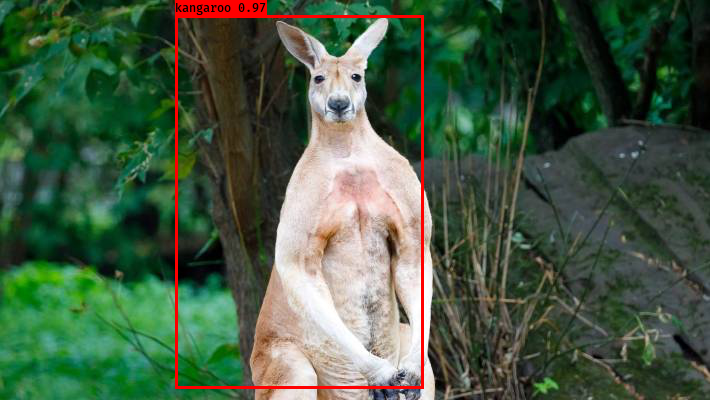

In [0]:
r_image

In [0]:
import cv2
import numpy as np
from PIL import Image
import timeit

# %cd '/content/gdrive/My Drive/Day050/keras-yolo3-master/'
yolo_model = YOLO(model_path=log_dir + 'trained_weights_final.h5', classes_path=classes_path)

starttime = timeit.default_timer()
cap = cv2.VideoCapture('/content/Raccoon.mp4')

# 使用 XVID 編碼
fourcc = cv2.VideoWriter_fourcc(*'XVID')

# 建立 VideoWriter 物件，輸出影片至 output.avi
# FPS 值為 30.0，解析度為 1280*720
out = cv2.VideoWriter('raccoon.avi', fourcc, 30.0, (1280, 720))

k = 0
while(cap.isOpened()):
    ret, frame = cap.read()
    if ret == True:
        # 寫入影格
        image = Image.fromarray(frame)
        image = np.array(yolo_model.detect_image(image))
        out.write(image)
        k += 1
    else:
        break
    
# 釋放所有資源
cap.release()
out.release()

print('共耗時:',round((timeit.default_timer() - starttime), 2), '秒，FPS:', round(k/(timeit.default_timer() - starttime), 2))

Streaming output truncated to the last 5000 lines.
(416, 416, 3)
Found 1 boxes for img
raccoon 0.64 (327, 121) (1167, 633)
0.07053751000012198
(416, 416, 3)
Found 1 boxes for img
raccoon 0.62 (318, 127) (1177, 638)
0.07040544000028603
(416, 416, 3)
Found 1 boxes for img
raccoon 0.75 (317, 132) (1173, 634)
0.07057220499973482
(416, 416, 3)
Found 1 boxes for img
raccoon 0.66 (319, 133) (1174, 640)
0.0756338730002426
(416, 416, 3)
Found 1 boxes for img
raccoon 0.70 (342, 131) (1160, 634)
0.07096737399979247
(416, 416, 3)
Found 1 boxes for img
raccoon 0.70 (365, 127) (1137, 634)
0.07099630999982764
(416, 416, 3)
Found 1 boxes for img
raccoon 0.60 (355, 117) (1147, 637)
0.0764689810002892
(416, 416, 3)
Found 1 boxes for img
raccoon 0.57 (363, 117) (1142, 639)
0.07016364699984479
(416, 416, 3)
Found 1 boxes for img
raccoon 0.90 (115, 0) (1280, 720)
0.07243278700025257
(416, 416, 3)
Found 1 boxes for img
raccoon 0.89 (117, 0) (1280, 720)
0.07114114699970742
(416, 416, 3)
Found 1 boxes for img